<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Classification/blob/main/Image_classification_with_Swin_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification using Swin Transformers, a general-purpose backbone for computer vision.

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 26/6/2024
<br>
**Reference:**
- [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](
https://doi.org/10.48550/arXiv.2103.14030)

- [Keras Example](https://keras.io/examples/vision/swin_transformers/)


## Swin Transformer for Image Classification

- **Model**: Swin Transformer (Shifted Window Transformer) by Liu et al.
- **Architecture**:
  - **Hierarchical Design**: Uses a multi-level structure to process images.
  - **Shifted Windows**: Computes self-attention within non-overlapping local windows, shifted to allow cross-window connections.
  - **Efficiency**: Limits self-attention computation to local regions, improving efficiency.
  - **Scalability**: Capable of capturing information at different scales with linear computational complexity in relation to image size.
- **Application**: Demonstrated on the CIFAR-100 dataset, suitable as a general-purpose backbone for various computer vision tasks.
- **Requirements**: TensorFlow 2.5 or higher.

<br>

![](https://ars.els-cdn.com/content/image/1-s2.0-S0952197623008539-gr4.jpg)

## Imports

In [1]:
!pip install --upgrade keras

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import ops

## Configure the hyperparameters

In [3]:
num_classes = 100
input_shape = (32, 32, 3)

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 10 #40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

## Prepare the CIFAR-100 dataset

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

num_train_samples = int(len(x_train) * (1 - validation_split))
num_val_samples = len(x_train) - num_train_samples

x_train, x_val = np.split(x_train, [num_train_samples])
y_train, y_val = np.split(y_train, [num_train_samples])

print(f'x_train shape: {x_train.shape} - y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape} - y_test shape: {y_test.shape}')

x_train shape: (45000, 32, 32, 3) - y_train shape: (45000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


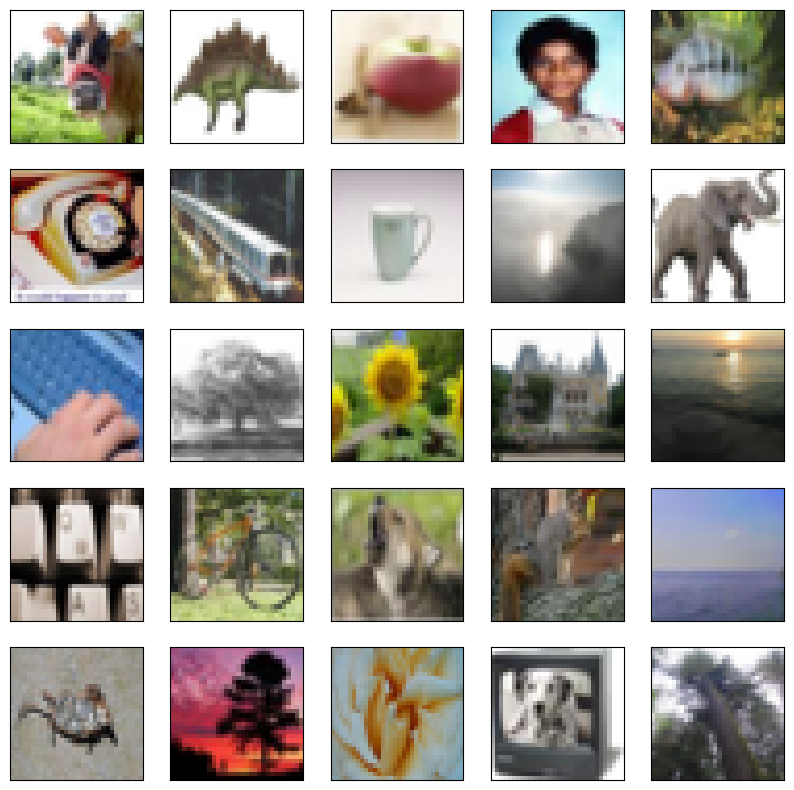

In [5]:
# Visualize the data
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i])
plt.show()

## Helper functions

We create two helper functions to help us **get a sequence of patches** from the image, **merge patches**, and apply **dropout**.

In [6]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows

In [7]:
def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x

## Window based multi-head self-attention

Window-based self-attention aims to reduce this computational complexity by restricting the self-attention mechanism to local windows of tokens. Here’s how it works:

- **Divide Tokens into Non-Overlapping Windows:** The sequence of tokens is divided into smaller, non-overlapping windows. Each window contains a fixed number of tokens.

- **Local Self-Attention:** Self-attention is performed independently within each window. Tokens in one window do not attend to tokens in another window.

- **Linear Complexity:** Because the attention computation is restricted to smaller windows, the complexity is reduced to
𝑂
(
𝑛
)
O(n), making it more scalable.


![](https://www.researchgate.net/publication/364953026/figure/fig4/AS:11431281123829682@1677817231658/Window-based-Multi-head-Self-Attention-W-MSA.png)

In [8]:
class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

## The complete Swin Transformer model

### Complete Swin Transformer Model

The Swin Transformer enhances the Vision Transformer (ViT) architecture by replacing the standard multi-head attention (MHA) with shifted windows attention. This modification addresses the challenge of modeling long-range dependencies while maintaining computational efficiency.

### Key Components:

1. **Shifted Windows Attention (SWA)**:
   - Replaces standard MHA with window-based attention.
   - Windows are shifted to ensure cross-window connections, enhancing the model's ability to capture global context.

2. **2-Layer MLP**:
   - Composed of two Dense layers and two Dropout layers.
   - Uses GELU nonlinearity between the layers.
   - Simpler than models using more complex MLP structures like ResNet-50.

3. **LayerNormalization**:
   - Applied before each MSA (Multi-Head Self-Attention) layer and each MLP layer.
   - Ensures stable training and better convergence.

4. **Residual Connections**:
   - Added after each MSA layer and each MLP layer.
   - Helps in gradient flow and prevents vanishing/exploding gradient problems.

### Model Structure:

1. **Shifted Window-based MHA Layer**:
   - Divides the image into non-overlapping windows.
   - Applies MHA within each window.
   - Shifts the windows and repeats the process to capture interactions between different windows.

2. **2-Layer MLP**:
   - First Dense layer followed by GELU nonlinearity.
   - Dropout layer for regularization.
   - Second Dense layer followed by another Dropout layer.

3. **LayerNormalization**:
   - Ensures normalized inputs for MSA and MLP layers.

4. **Residual Connections**:
   - Adds input to the output of MSA and MLP layers, aiding in stable training.


In [9]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

## Model training and evaluation

### Extract and embed patches

In [10]:
# Using tf ops since it is only used in tf.data
def patch_extract(images):
  batch_size = tf.shape(images)[0]
  patches = tf.image.extract_patches(
      images=images,
      sizes=(1, patch_size[0], patch_size[1], 1),
      strides=(1, patch_size[0], patch_size[1], 1),
      rates=(1, 1, 1, 1),
      padding='VALID'
  )
  patch_dim = patches.shape[-1]
  patch_num = patches.shape[1]
  return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

class PatchEmbedding(layers.Layer):
  def __init__(self, num_patch, embed_dim, **kwargs):
    super().__init__(**kwargs)
    self.num_patch = num_patch
    self.proj = layers.Dense(embed_dim)
    self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

  def call(self, patch):
    pos = ops.arange(start=0, stop=self.num_patch)
    return self.proj(patch) + self.pos_embed(pos)

class PatchMerging(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear = layers.Dense(2 * embed_dim)

    def call(self, x):
        height, width = self.num_patch
        _, seq_len, _ = x.shape  # Get the sequence length instead of assuming 3 dimensions
        x0 = x[:, 0::2, :]  # Slice along the sequence length dimension
        x1 = x[:, 1::2, :]
        x = tf.concat([x0, x1], axis=-1)  # Concatenate along the feature dimension
        x = self.linear(x)
        return x

### Prepare the tf.data.Dataset

In [11]:
def augment(x):
  x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 3))
  x = tf.image.random_flip_left_right(x)
  return x

dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [12]:
dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [13]:
dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Build the model

In [14]:
input = layers.Input(shape=(256, 12))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

## Train on CIFAR-100

In [15]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    dataset,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=dataset_val,
)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 128s 213ms/step - accuracy: 0.0517 - loss: 4.3847 - top-5-accuracy: 0.1777 - val_accuracy: 0.1292 - val_loss: 3.8534 - val_top-5-accuracy: 0.3816
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 42s 37ms/step - accuracy: 0.1557 - loss: 3.7449 - top-5-accuracy: 0.4160 - val_accuracy: 0.1920 - val_loss: 3.5951 - val_top-5-accuracy: 0.4812
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.2111 - loss: 3.5130 - top-5-accuracy: 0.4975 - val_accuracy: 0.2368 - val_loss: 3.4124 - val_top-5-accuracy: 0.5434
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.2456 - loss: 3.3649 - top-5-accuracy: 0.5491 - val_accuracy: 0.2632 - val_loss: 3.3057 - val_top-5-accuracy: 0.5762
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.2741 - loss: 3.2439 - top-5-accuracy: 0.5880 - val_accuracy: 0.2828 - val_loss: 3.2196 - val_top-5-accuracy: 0.5978
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.3012 - los

## Visualize the training progress of the model

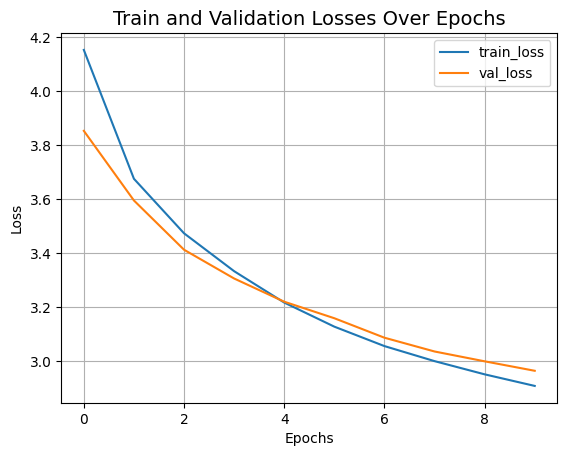

In [16]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

## Results

In [17]:
loss, accuracy, top_5_accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - accuracy: 0.3656 - loss: 2.9455 - top-5-accuracy: 0.6749
Test loss: 2.94
Test accuracy: 36.61%
Test top 5 accuracy: 67.6%
